In [95]:
import tensorflow as tf
import os
import random
import numpy as np
 
from tqdm import tqdm 

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

seed = 42
np.random.seed = seed

IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 1

TRAIN_PATH = r'C:\Users\medicai\Desktop\orginal_clasification_images\data_without_augmentaion\resize_512x512\train'
TEST_PATH = r'C:\Users\medicai\Desktop\orginal_clasification_images\data_without_augmentaion\resize_512x512\test'


print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


2.10.1
Num GPUs Available:  4


Resizing training images and masks


100%|██████████| 1032/1032 [00:21<00:00, 47.91it/s]


Resizing test images


100%|██████████| 115/115 [00:00<00:00, 270.59it/s]


Done!


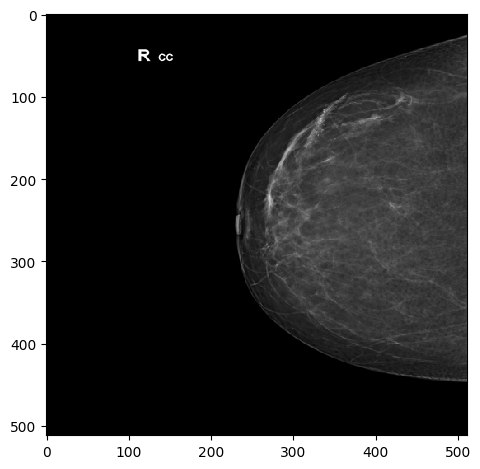

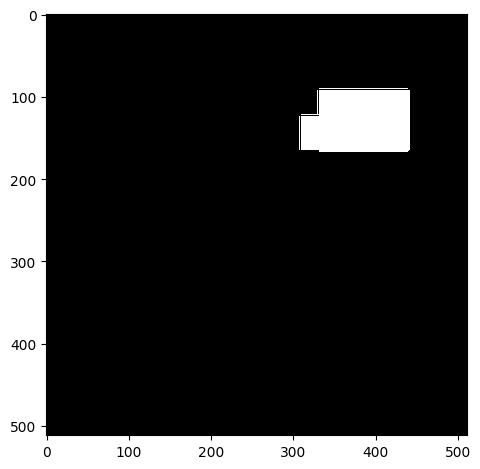

In [96]:
# Extract train IDs from filenames in the images directory
train_ids = [f.split('.')[0] for f in os.listdir(os.path.join(TRAIN_PATH, 'images')) if f.endswith('.png')]

# If you also need test IDs
test_ids = [f.split('.')[0] for f in os.listdir(os.path.join(TEST_PATH, 'images')) if f.endswith('.png')]


X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + '/images/' + id_  # Construct the full path
    img = imread(path + '.png')  # Read the image file
    
    # Check if the image is grayscale or RGB
    if len(img.shape) == 2:  # Grayscale image
        img = np.expand_dims(img, axis=-1)  # Add a channel dimension
    
    
    # If the image is still grayscale, ensure it matches the expected shape
    if img.shape[-1] == 1 and IMG_CHANNELS == 3:  # Convert to RGB by duplicating channels
        img = np.repeat(img, IMG_CHANNELS, axis=-1)
    
    X_train[n] = img  # Fill empty X_train with values from img
    
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
    for mask_file in next(os.walk(TRAIN_PATH + '/masks/'))[2]:
        if mask_file.startswith(id_):  # Check if the mask file matches the image ID
            mask_ = imread(TRAIN_PATH + '/masks/' + mask_file)
            mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
            mask = np.maximum(mask, mask_)
    
    Y_train[n] = mask


# test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Resizing test images') 
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):

    path = os.path.join(TEST_PATH, 'images', id_) # Construct the full path
    img = imread(path + '.png')   # to read the img file

    if len(img.shape) == 2: # gray
        img= np.expand_dims(img, axis=-1) #add a channel dimention
 
    sizes_test.append([img.shape[0], img.shape[1]])

    X_test[n] = img

print('Done!')

image_x = random.randint(0, len(train_ids))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()

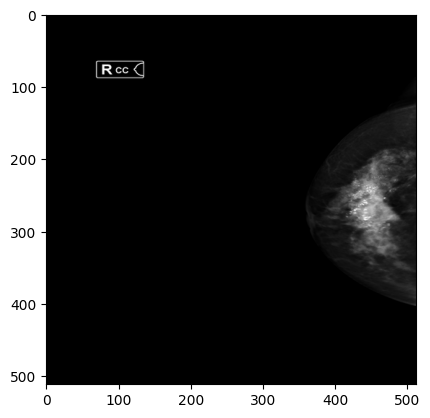

In [97]:
# Example to verify if the images are loaded correctly
import matplotlib.pyplot as plt
img = imread(os.path.join(TRAIN_PATH, 'images', train_ids[0] + '.png'))
plt.imshow(img, cmap='gray')
plt.show()


Resizing test masks


100%|██████████| 115/115 [00:01<00:00, 66.67it/s]


Done!


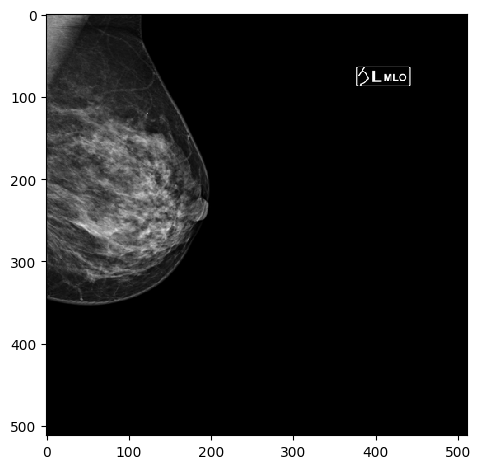

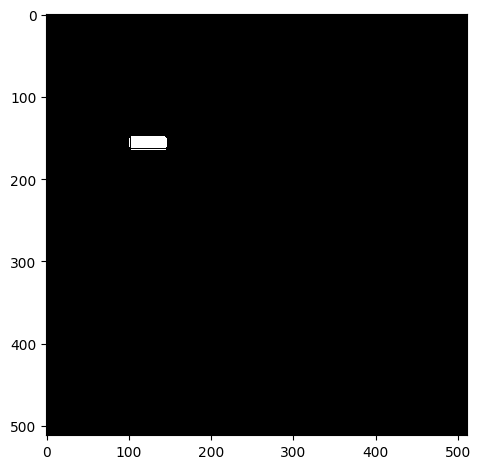

In [98]:
# Initialize the Y_test array
Y_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

print('Resizing test masks')
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
    for mask_file in next(os.walk(os.path.join(TEST_PATH, 'masks')))[2]:
        if mask_file.startswith(id_):  # Check if the mask file matches the image ID
            mask_ = imread(os.path.join(TEST_PATH, 'masks', mask_file))
            mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
            mask = np.maximum(mask, mask_)
    
    Y_test[n] = mask

print('Done!')

image_x = random.randint(0, len(test_ids))
imshow(X_test[image_x])
plt.show()
imshow(np.squeeze(Y_test[image_x]))
plt.show()

In [99]:
#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.01)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.01)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.02)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.02)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.03)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.02)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.02)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.01)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.01)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])


# Custom IoU Metric
def mean_iou(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Binarize predictions
    intersect = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32), axis=[1, 2, 3])
    union = tf.reduce_sum(tf.cast(y_true + y_pred, tf.float32), axis=[1, 2, 3]) - intersect
    iou = tf.where(union == 0, tf.ones_like(intersect), intersect / union)
    return tf.reduce_mean(iou)

# Compile the model with the custom IoU metric
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])

#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 lambda_10 (Lambda)             (None, 512, 512, 1)  0           ['input_11[0][0]']               
                                                                                                  
 conv2d_172 (Conv2D)            (None, 512, 512, 16  160         ['lambda_10[0][0]']              
                                )                                                                 
                                                                                            

In [100]:
print(tf.__version__)


2.10.1


cell 5: final step

In [101]:
################################
# Modelcheckpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_512_6.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=50, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs'),
        checkpointer]

# Fitting the model
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=300, callbacks=callbacks)
####################################



Epoch 1/300
58/58 [==============================] - ETA: 0s - loss: 0.1697 - mean_iou: 0.0030
Epoch 1: val_loss improved from inf to 0.07956, saving model to model_512_6.h5
58/58 [==============================] - 14s 208ms/step - loss: 0.1697 - mean_iou: 0.0030 - val_loss: 0.0796 - val_mean_iou: 0.0000e+00
Epoch 2/300
58/58 [==============================] - ETA: 0s - loss: 0.0664 - mean_iou: 0.0000e+00
Epoch 2: val_loss did not improve from 0.07956
58/58 [==============================] - 11s 185ms/step - loss: 0.0664 - mean_iou: 0.0000e+00 - val_loss: 0.0800 - val_mean_iou: 0.0000e+00
Epoch 3/300
58/58 [==============================] - ETA: 0s - loss: 0.0642 - mean_iou: 0.0000e+00
Epoch 3: val_loss improved from 0.07956 to 0.07886, saving model to model_512_6.h5
58/58 [==============================] - 12s 201ms/step - loss: 0.0642 - mean_iou: 0.0000e+00 - val_loss: 0.0789 - val_mean_iou: 0.0000e+00
Epoch 4/300
58/58 [==============================] - ETA: 0s - loss: 0.0611 - mean

4/4 [==============================] - 1s 198ms/step
Accuracy on the test set: 0.9893
Mean Dice Coefficient on the test set: 0.3627
Mean IoU on the test set: 0.2724


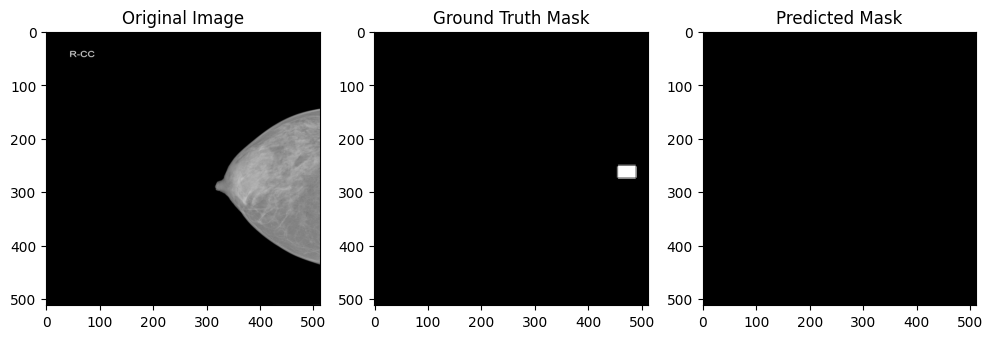

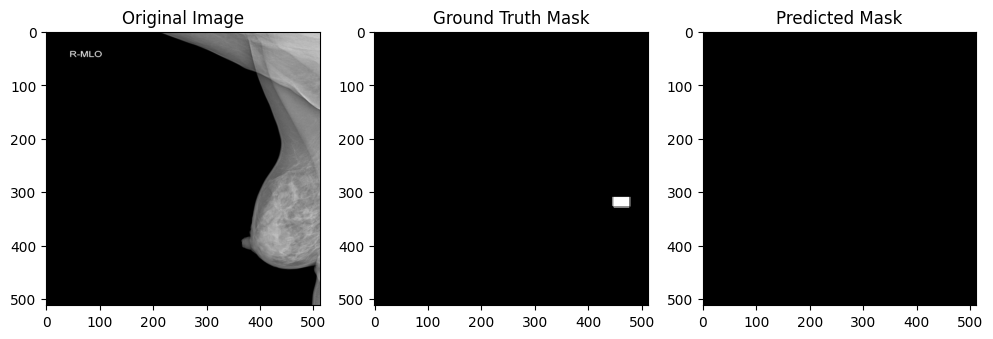

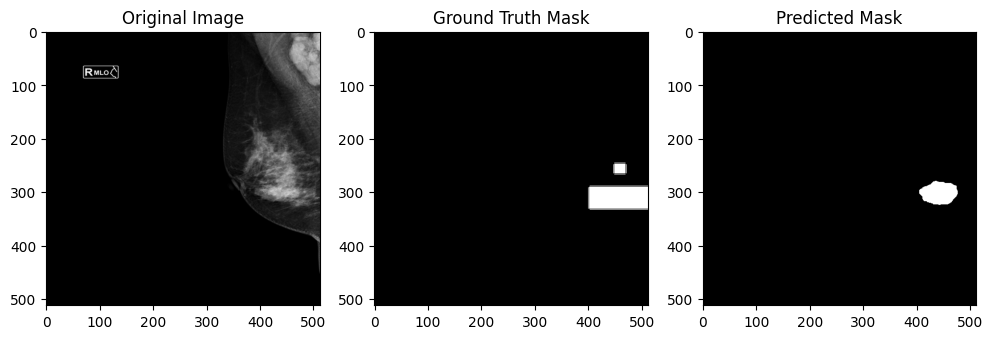

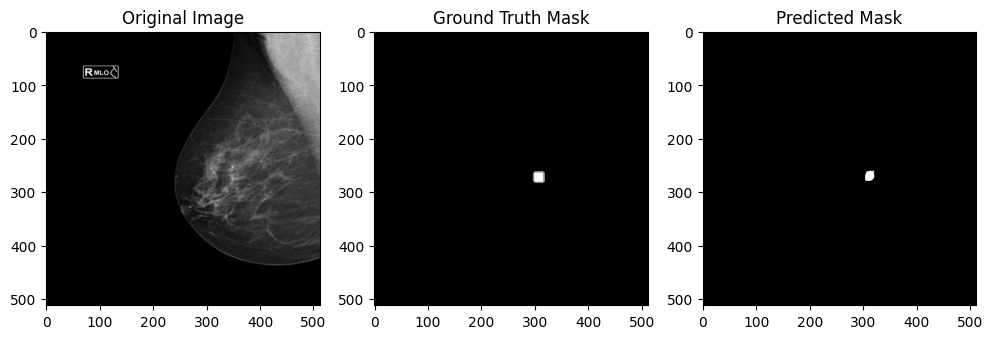

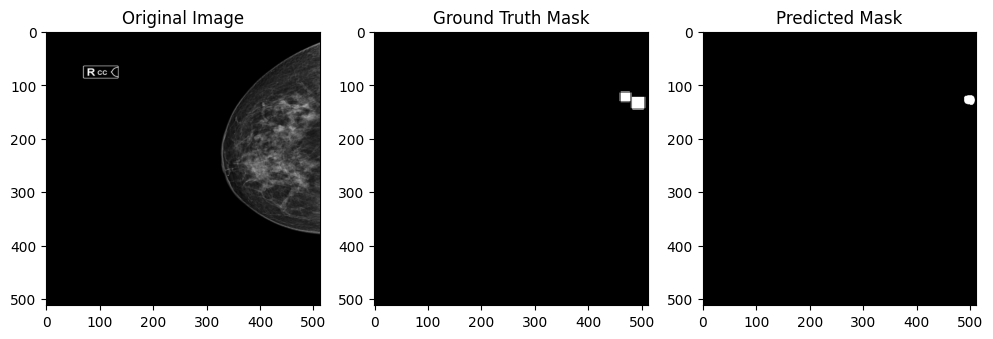

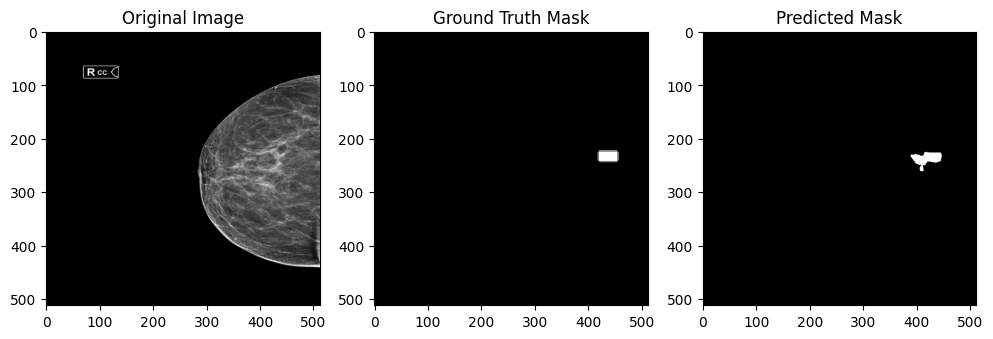

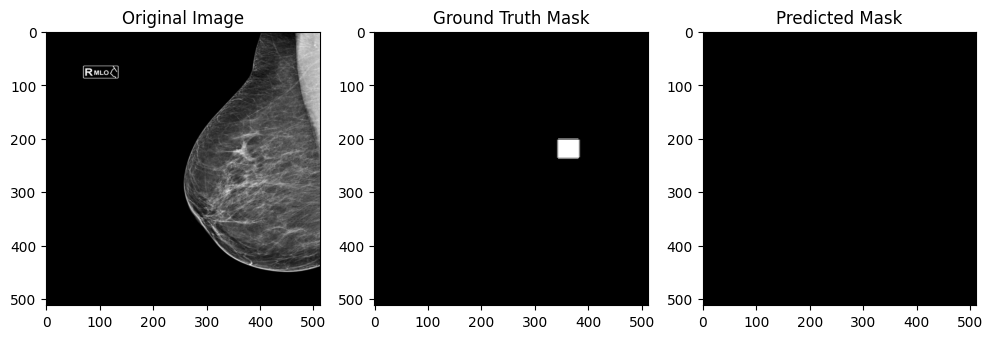

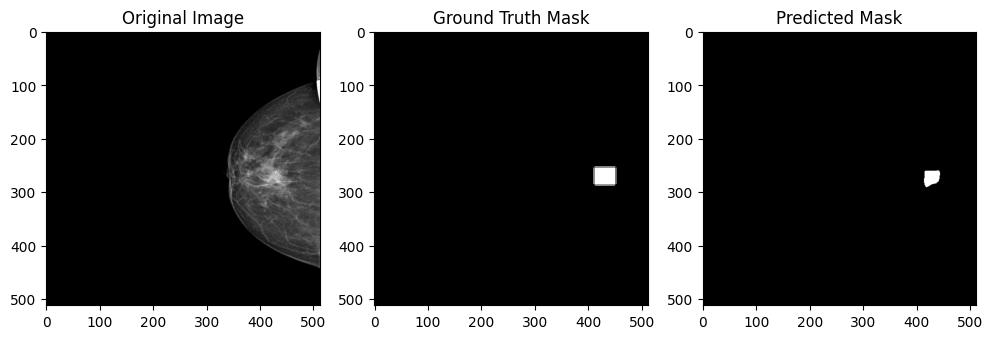

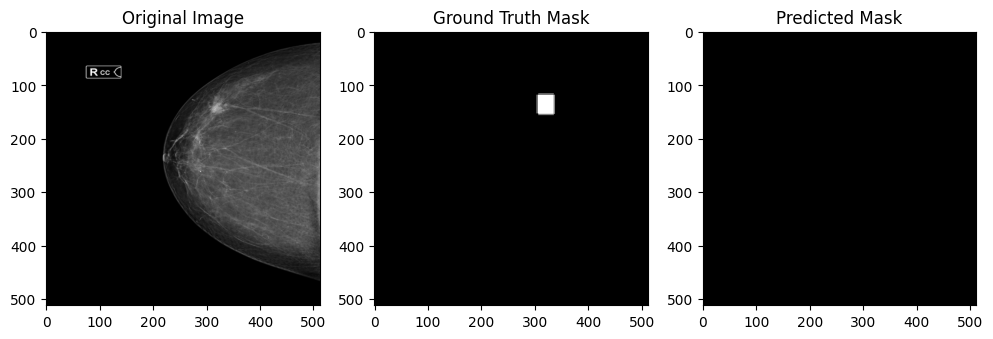

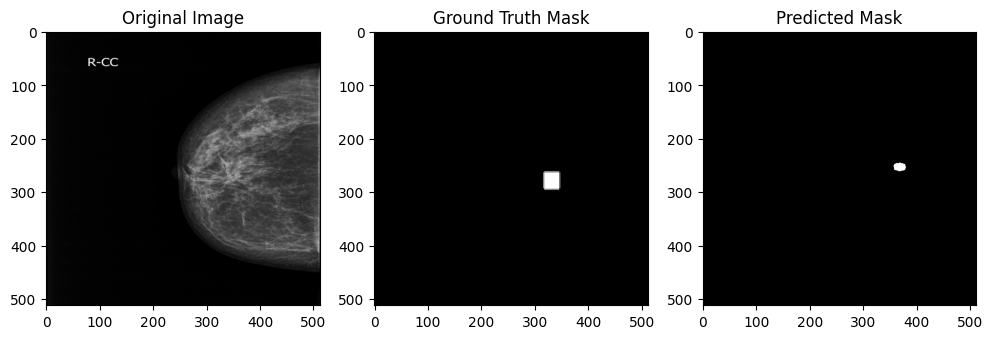

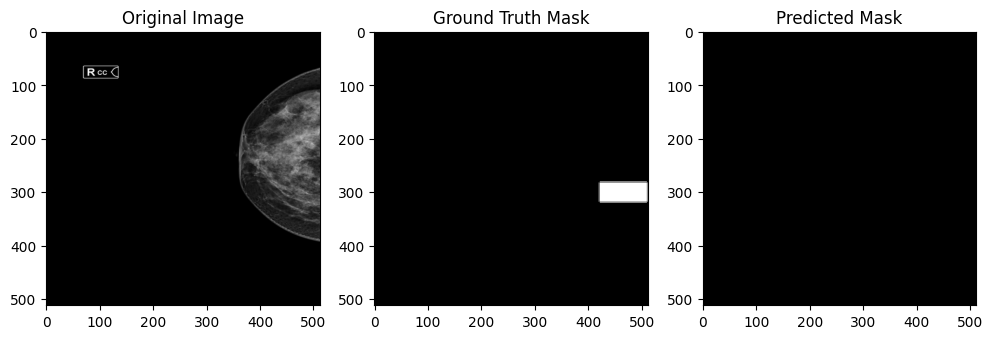

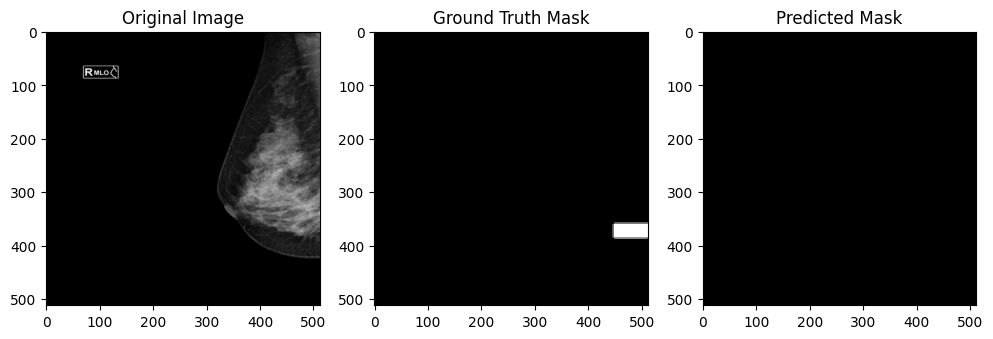

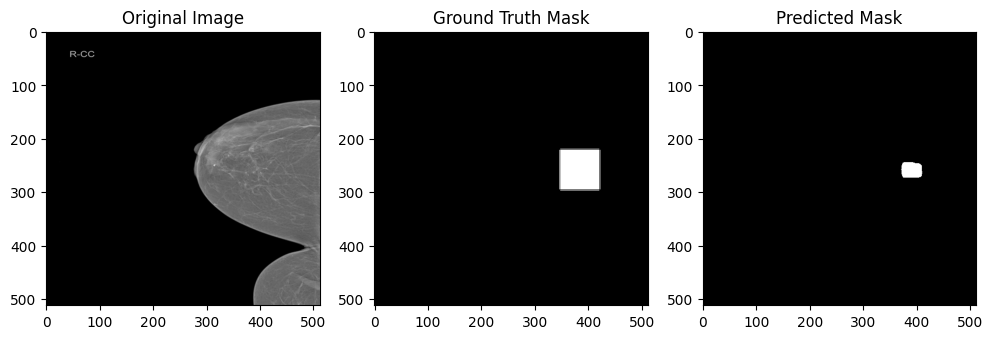

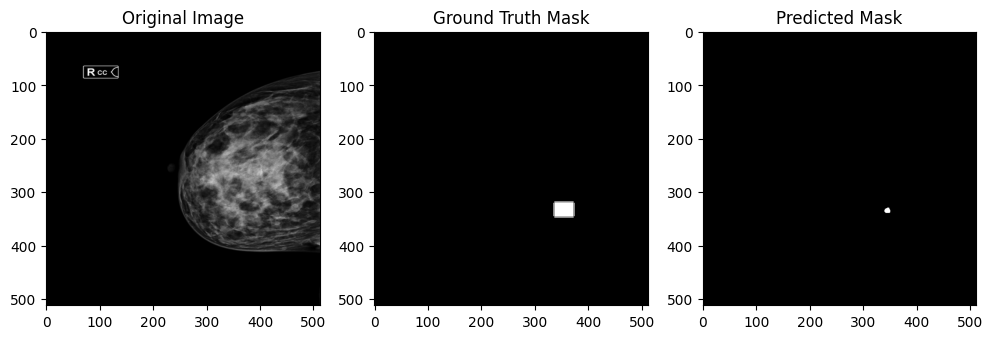

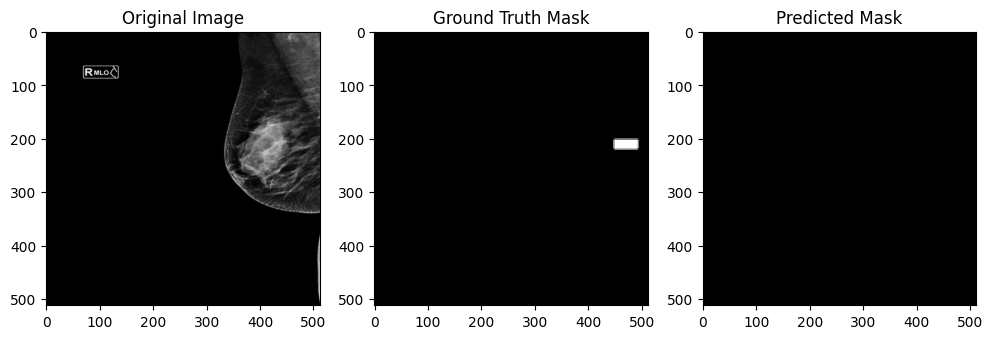

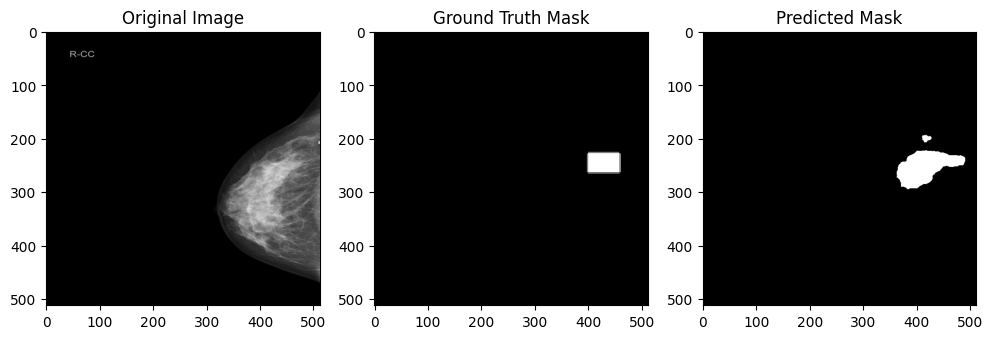

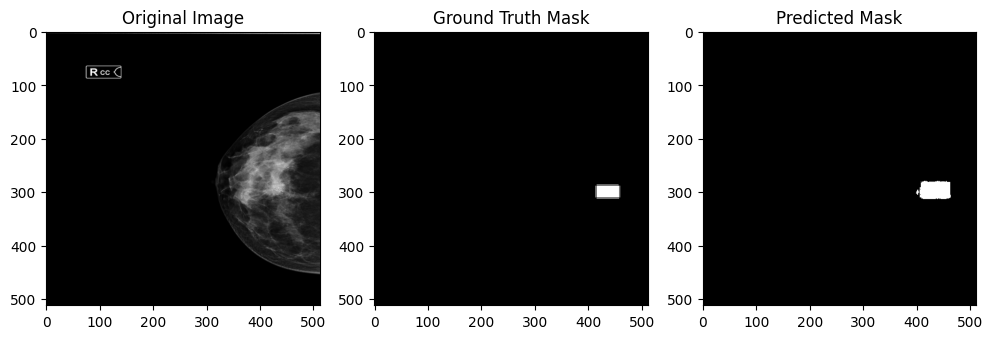

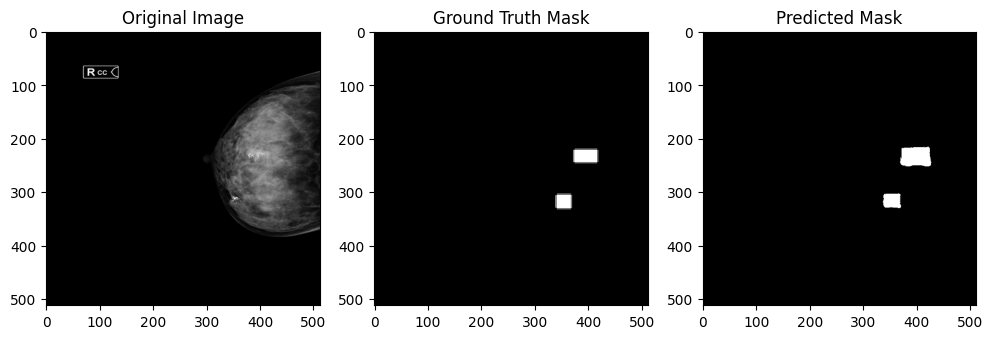

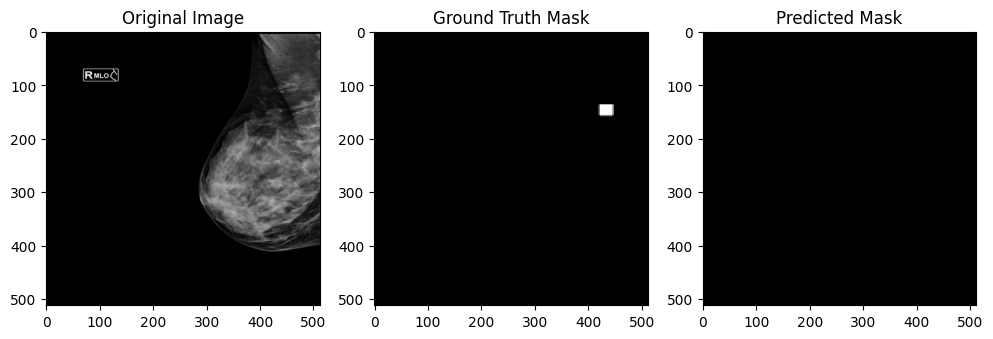

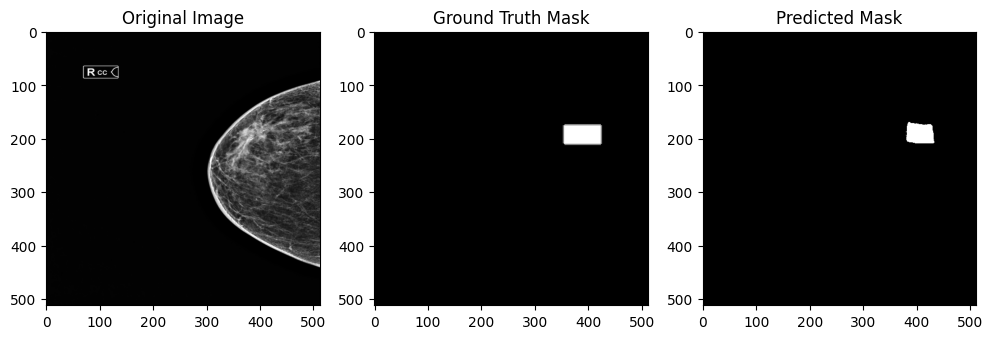

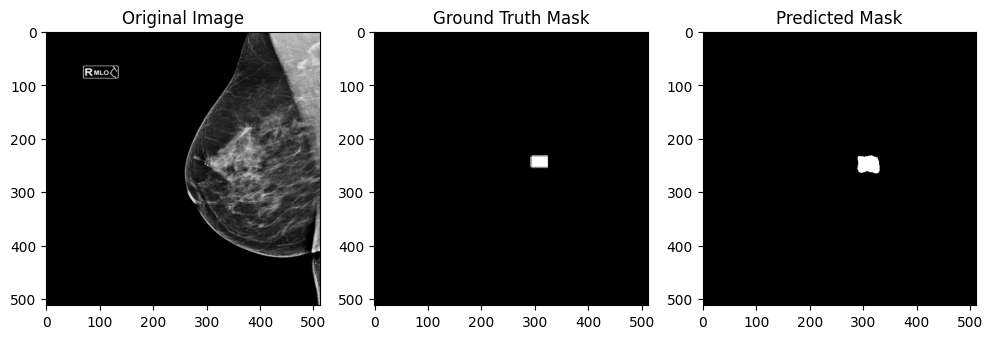

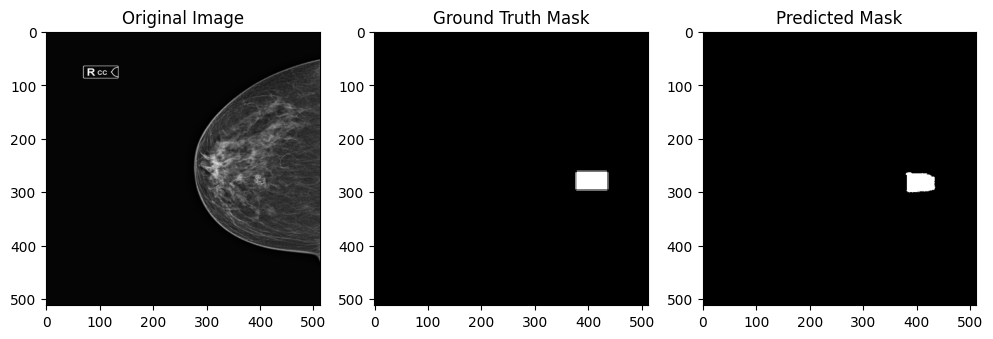

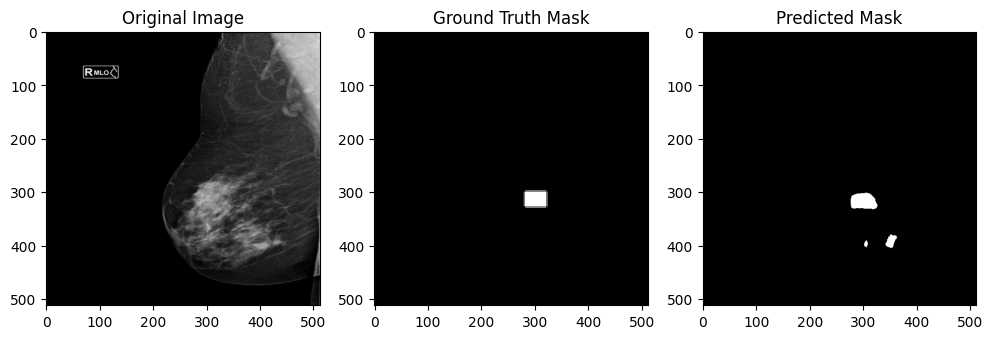

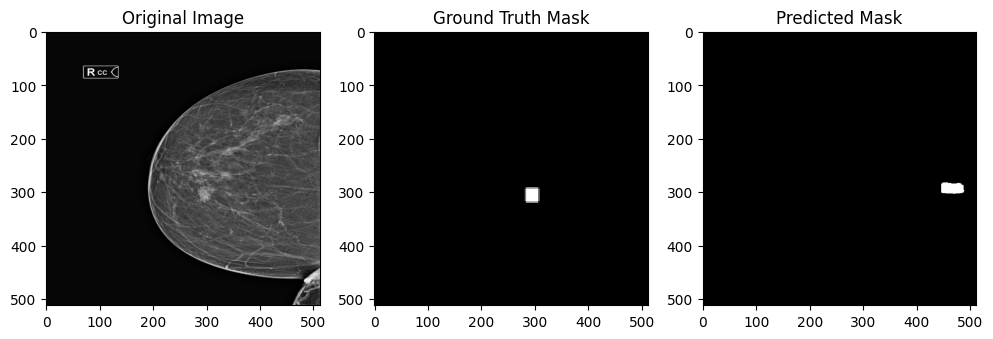

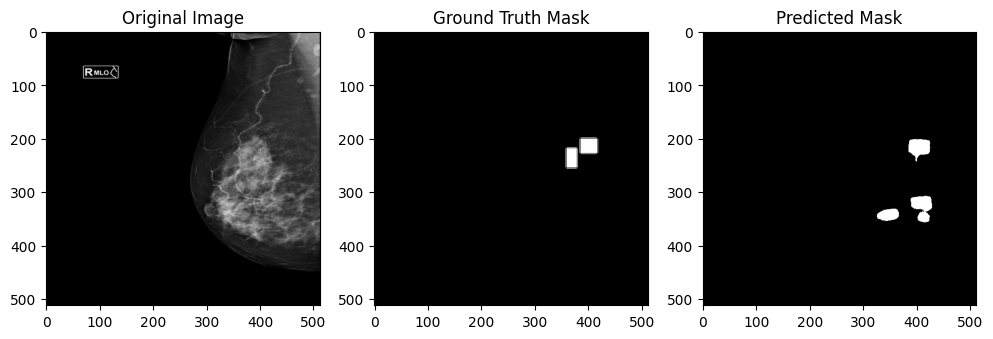

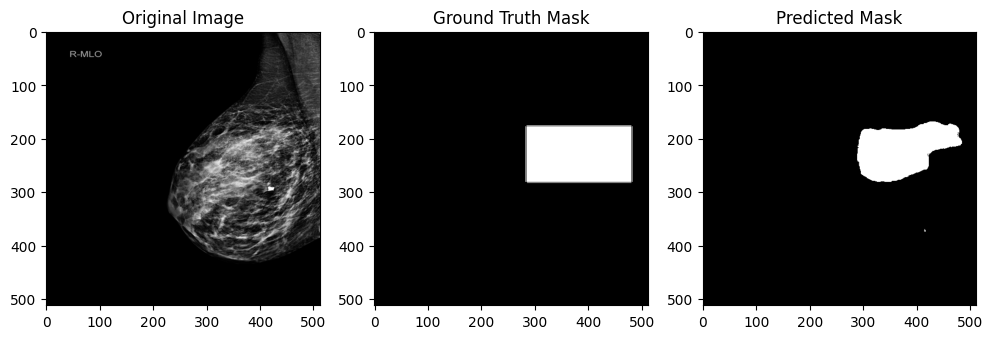

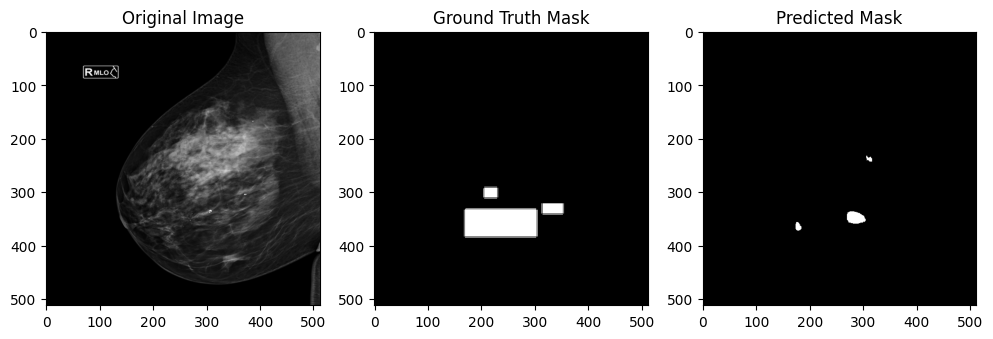

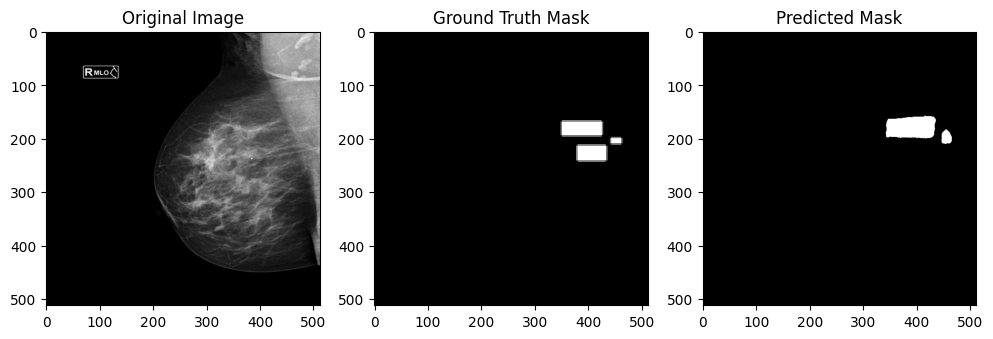

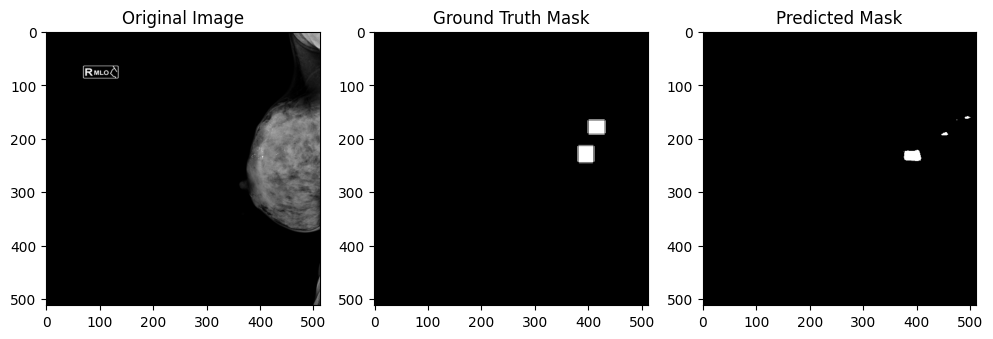

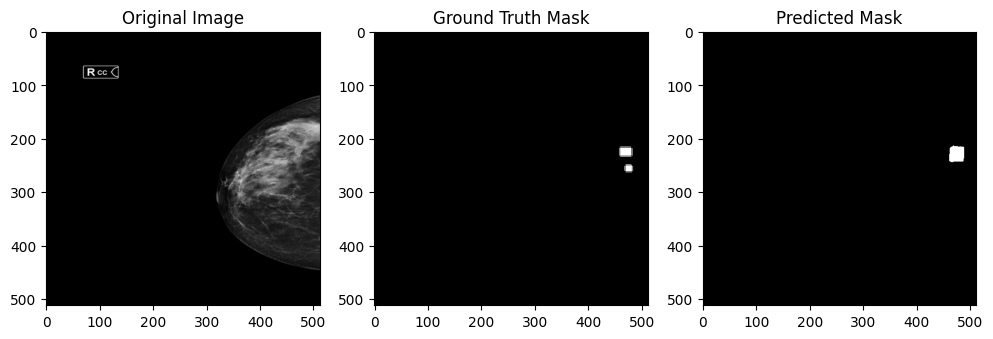

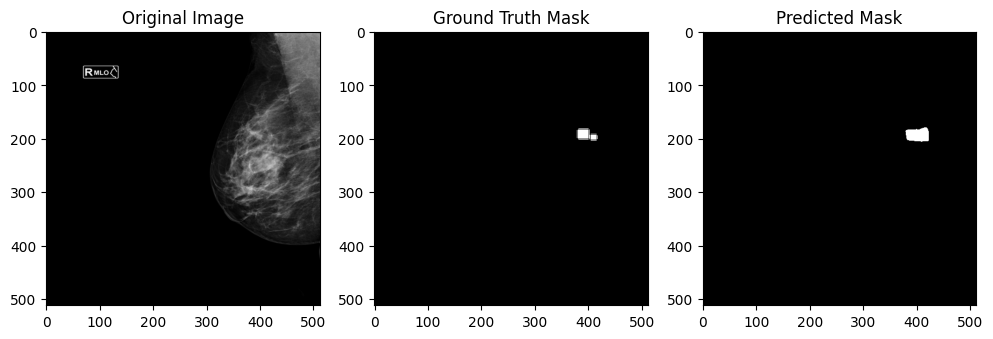

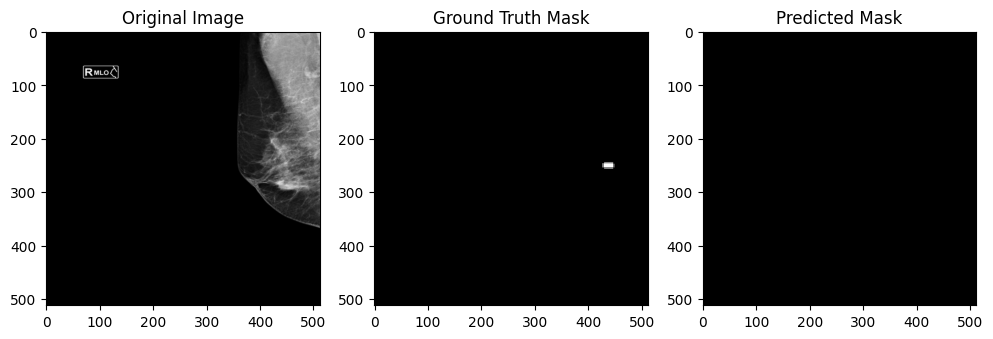

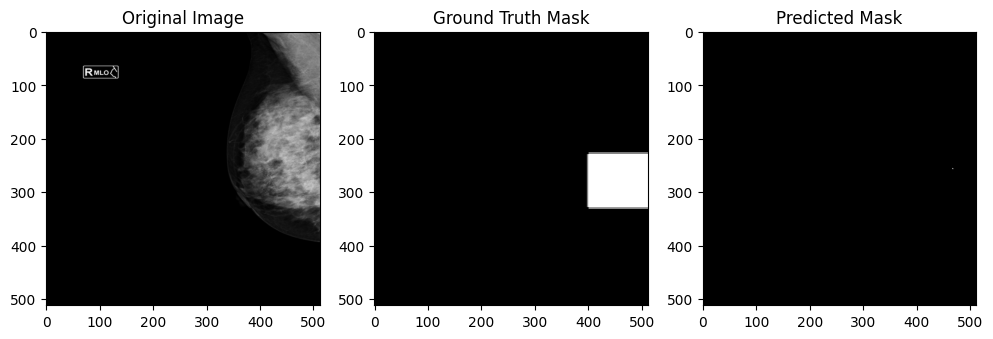

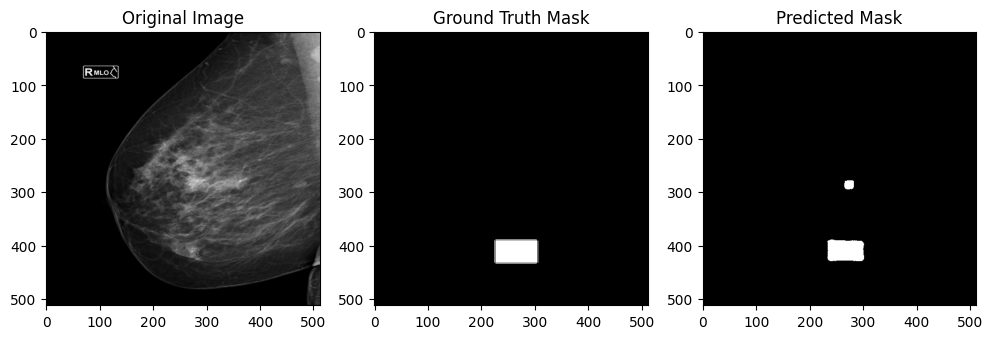

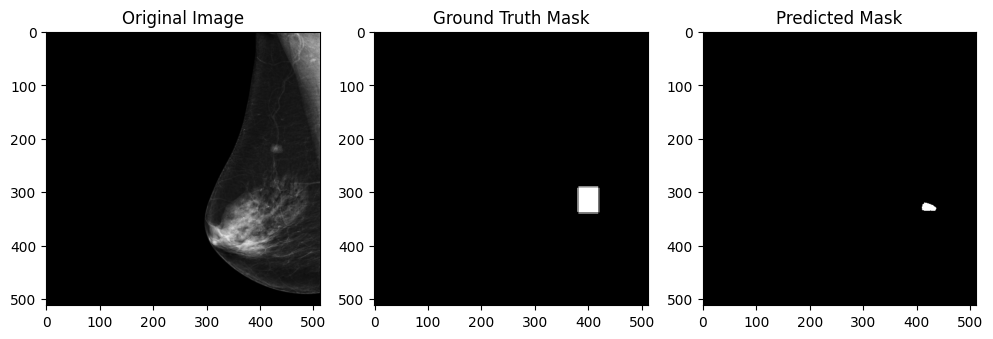

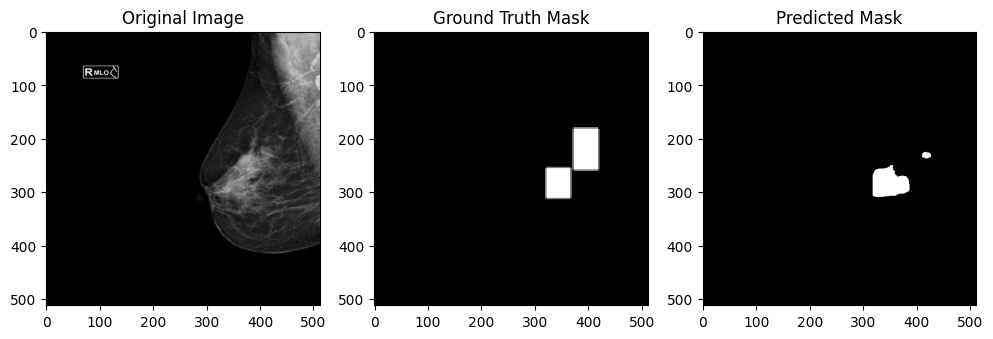

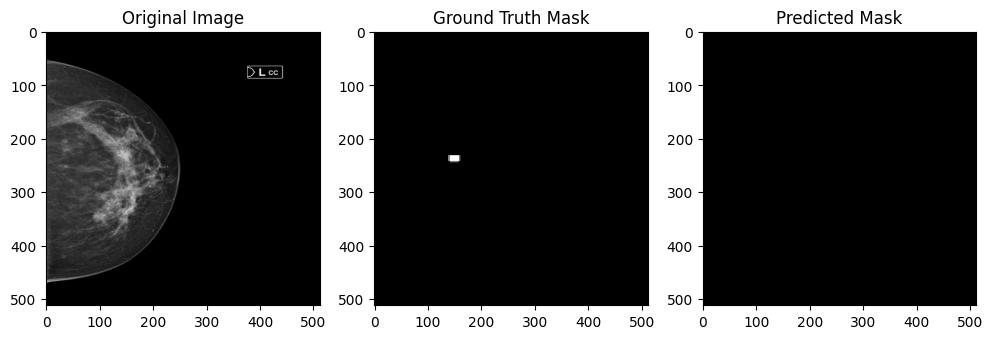

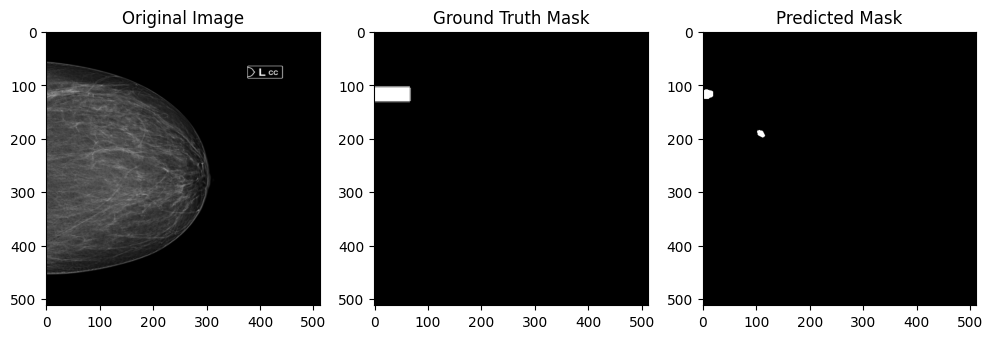

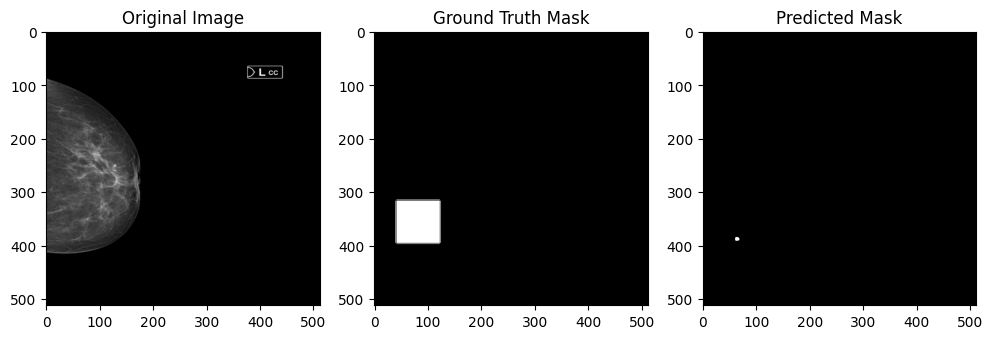

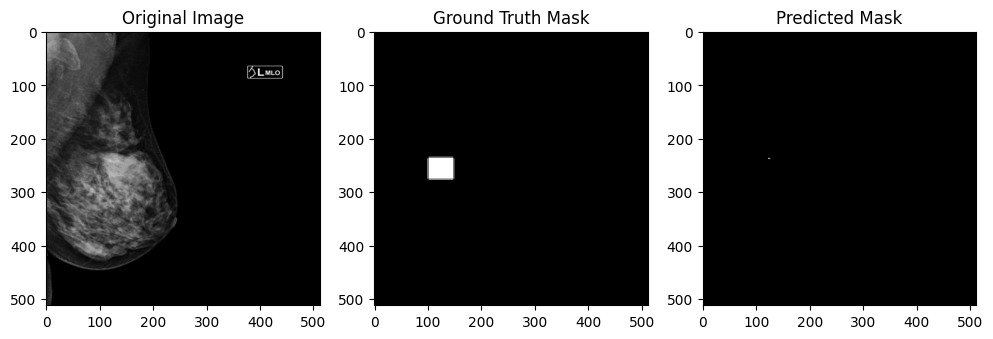

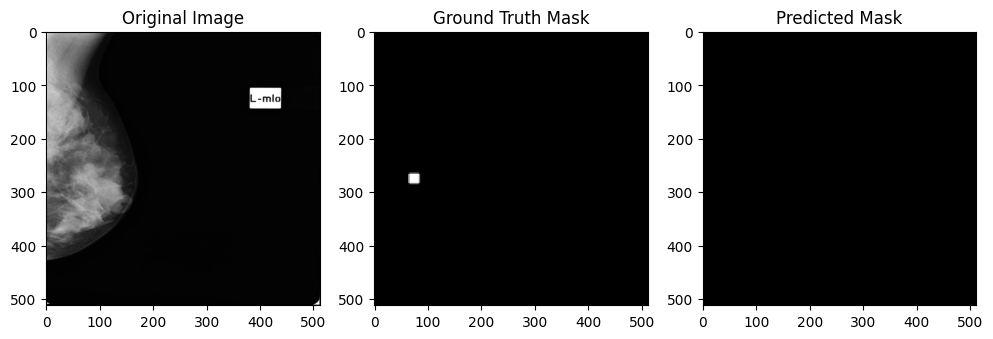

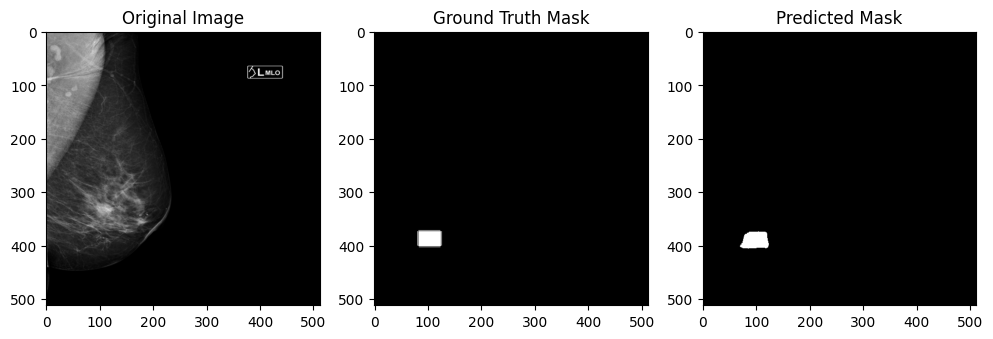

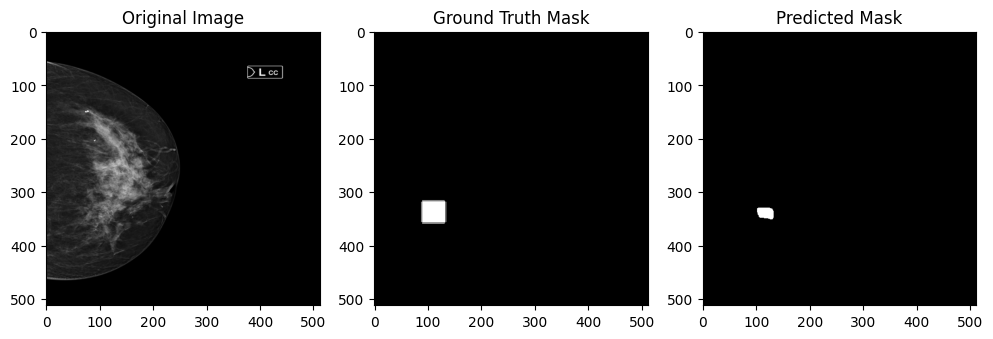

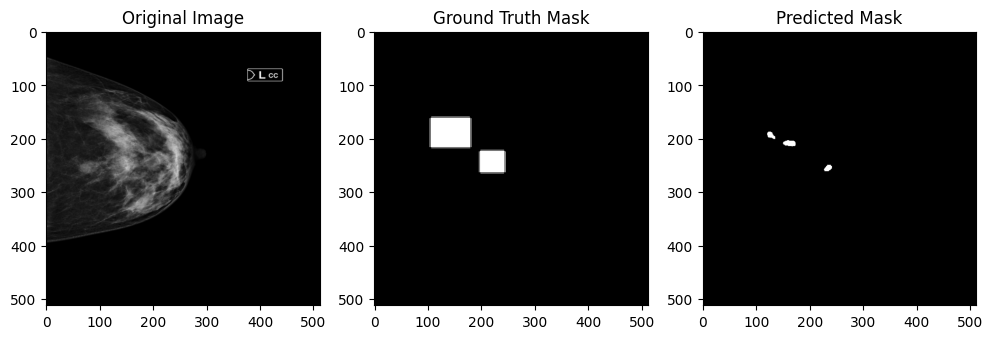

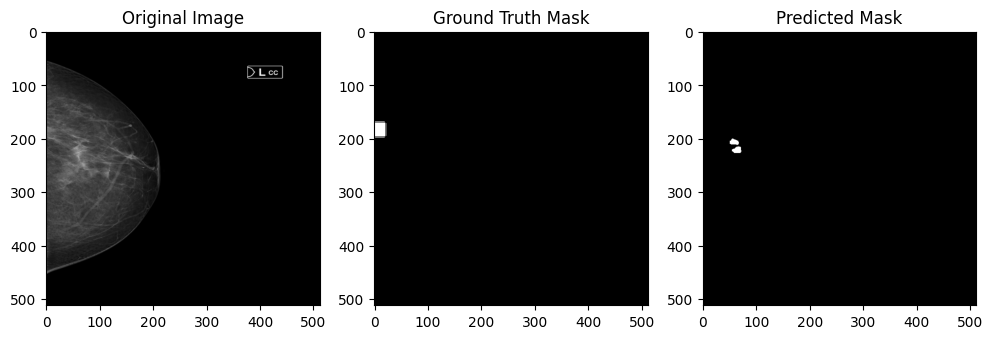

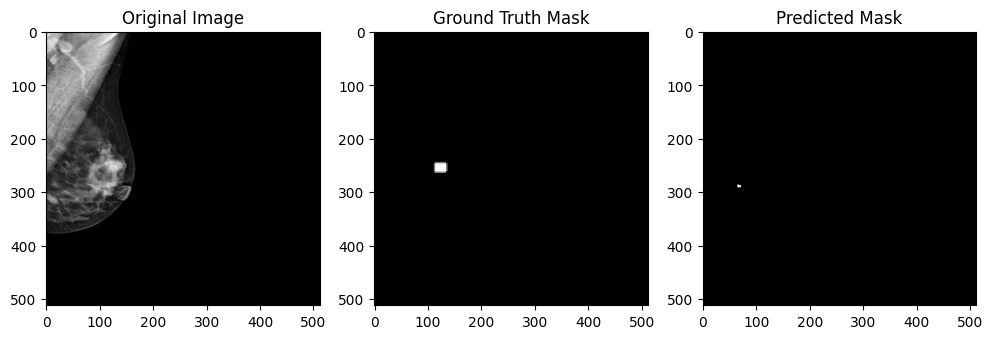

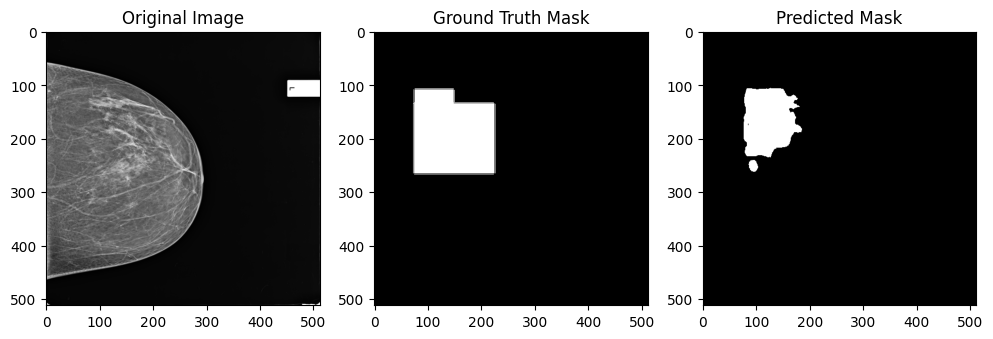

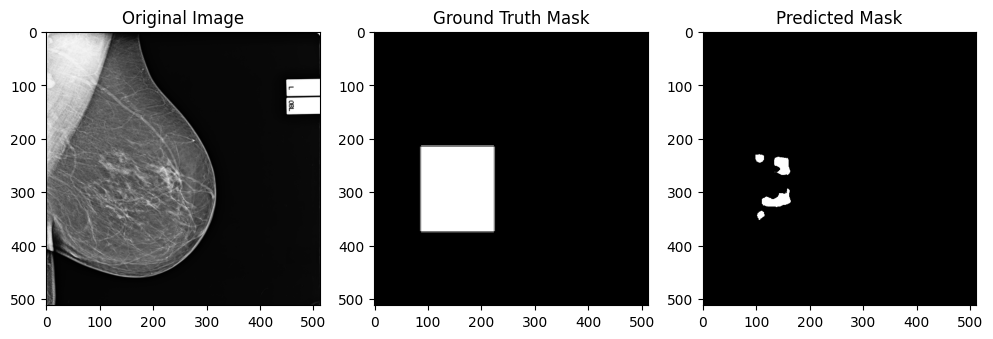

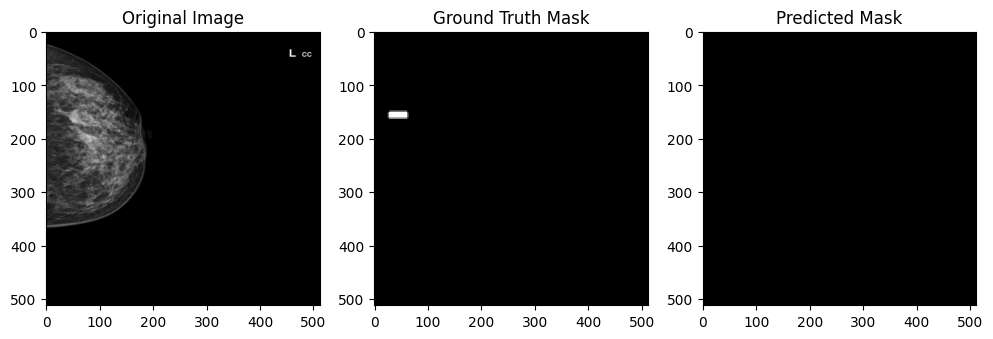

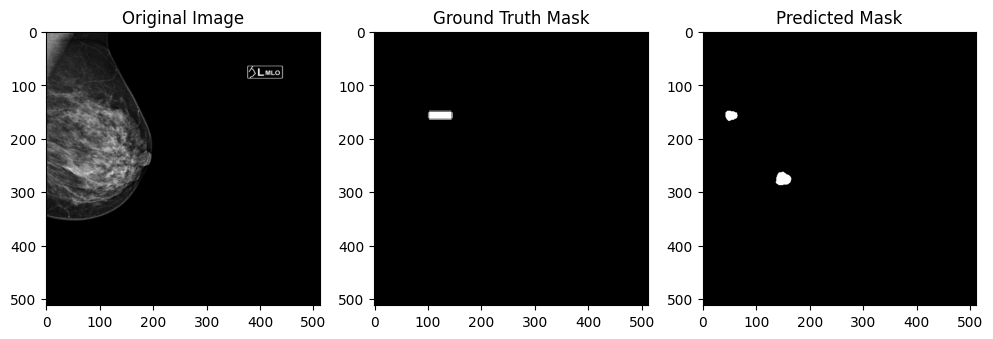

In [102]:
# Predict on the test set
preds_test = model.predict(X_test, verbose=1)

# Binarize the predictions (assuming binary classification)
preds_test_bin = (preds_test > 0.5).astype(np.uint8)

from sklearn.metrics import accuracy_score

# Flatten the arrays for accuracy calculation
accuracy = accuracy_score(Y_test.flatten(), preds_test_bin.flatten())
print(f'Accuracy on the test set: {accuracy:.4f}')

def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    sum_y_true_y_pred = np.sum(y_true) + np.sum(y_pred)
    
    if sum_y_true_y_pred == 0:
        return 1.0  # Perfect match if both are empty
    
    return (2. * intersection) / sum_y_true_y_pred

def iou(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    
    if union == 0:
        return 1.0  # Perfect match if both are empty
    
    return intersection / union

# Calculate Dice coefficient and IoU for each image
dice_scores = [dice_coefficient(Y_test[i], preds_test_bin[i]) for i in range(len(Y_test))]
mean_dice_score = np.mean(dice_scores)
print(f'Mean Dice Coefficient on the test set: {mean_dice_score:.4f}')

iou_scores = [iou(Y_test[i], preds_test_bin[i]) for i in range(len(Y_test))]
mean_iou_score = np.mean(iou_scores)
print(f'Mean IoU on the test set: {mean_iou_score:.4f}')

import matplotlib.pyplot as plt

# Visualize a few test predictions
for i in range(50):
    plt.figure(figsize=(12, 4))
    
    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(X_test[i].squeeze(), cmap='gray')
    plt.title('Original Image')
    
    # Ground truth mask
    plt.subplot(1, 3, 2)
    plt.imshow(Y_test[i].squeeze(), cmap='gray')
    plt.title('Ground Truth Mask')
    
    # Predicted mask
    plt.subplot(1, 3, 3)
    plt.imshow(preds_test_bin[i].squeeze(), cmap='gray')
    plt.title('Predicted Mask')
    
    plt.show()


Precision for Calcification: 0.7149
Recall for Calcification: 0.4021
F1 Score for Calcification: 0.5147


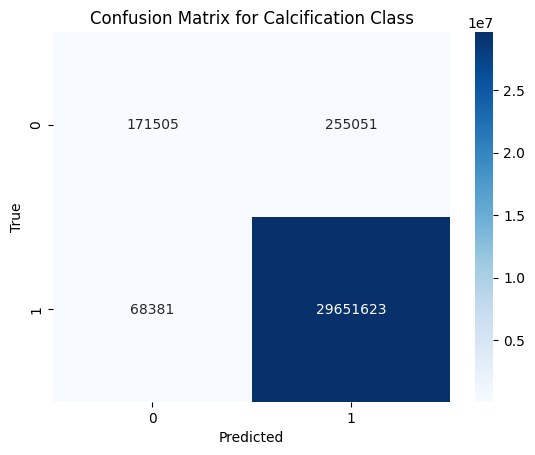

In [103]:
import numpy as np
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt


# Flatten the arrays to compare pixel-wise predictions
y_true_flattened = Y_test.flatten()
y_pred_flattened = preds_test_bin.flatten()

# Calculate confusion matrix, focus on calcification pixels (1) only
cm = confusion_matrix(y_true_flattened, y_pred_flattened, labels=[1, 0])

# If cm has only one class present, handle it accordingly
if cm.shape == (1, 1):  # Only one class present
    tn, fp, fn, tp = 0, 0, 0, cm[0, 0]
elif cm.shape == (2, 2):  # Both classes present
    tn, fp, fn, tp = cm.ravel()
else:
    tn, fp, fn, tp = 0, 0, 0, 0  # Handle cases where cm might be empty or not as expected

# Calculate precision, recall, and F1 score for calcification class (ignores background class)
precision, recall, f1, _ = precision_recall_fscore_support(y_true_flattened, y_pred_flattened, labels=[1], average='binary')

print(f"Precision for Calcification: {precision:.4f}")
print(f"Recall for Calcification: {recall:.4f}")
print(f"F1 Score for Calcification: {f1:.4f}")

# Optional: Visualize CM for calcification pixels only
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Calcification Class')
plt.show()


In [104]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Assuming you have already defined or imported:
# - iou(y_true, y_pred)

# Function to calculate Average Precision (AP) for a single image
def calculate_ap(precisions, recalls):
    precisions = np.array(precisions)
    recalls = np.array(recalls)
    
    # Sort by recall
    indices = np.argsort(recalls)
    precisions = precisions[indices]
    recalls = recalls[indices]
    
    # Compute the area under the precision-recall curve
    ap = np.trapz(precisions, recalls)
    return ap

# Function to calculate mAP for different IoU thresholds (mAP@.50:.95)
def calculate_map(Y_true, Y_pred, iou_thresholds=np.arange(0.5, 1.0, 0.05)):
    aps = []
    for threshold in iou_thresholds:
        aps_at_threshold = []
        for i in range(len(Y_true)):
            y_true_flat = Y_true[i].flatten()
            y_pred_flat = Y_pred[i].flatten()
            
            precisions, recalls, _ = precision_recall_curve(y_true_flat, y_pred_flat)
            ap = calculate_ap(precisions, recalls)
            aps_at_threshold.append(ap)
        
        # Calculate the average precision for this IoU threshold
        aps.append(np.mean(aps_at_threshold))
    
    # Calculate the mean Average Precision across all IoU thresholds
    mean_ap = np.mean(aps)
    return mean_ap

# Predict on the test set
preds_test = model.predict(X_test, verbose=1)

# Binarize the predictions (assuming binary classification)
preds_test_bin = (preds_test > 0.5).astype(np.uint8)

# Calculate mAP@.50:.95 for the test set
mAP_score = calculate_map(Y_test, preds_test_bin, iou_thresholds=np.arange(0.5, 1.0, 0.05))
print(f'mAP@.50:.95 on the test set: {mAP_score:.4f}')


4/4 [==============================] - 1s 207ms/step
mAP@.50:.95 on the test set: 0.5860
